# Generating DEA Intertidal Elevation using global satellite data using `odc-stac`

This notebook demonstrates how to generate DEA Intertidal Elevation outputs on Sentinel-2 and Landsat data loaded from Microsoft Planetary Computer using STAC metadata via `odc-stac`.

In this example, we generate an intertidal Digital Elevation Model for **Incheon, South Korea** using the [global EOT20 tide model](https://seanoe.org/data/00683/79489/). For more information on setting up tide models for DEA Intertidal, refer to the [wiki guide located here](https://github.com/GeoscienceAustralia/dea-coastlines/wiki/Setting-up-tidal-models-for-DEA-Coastlines).

<div class="alert alert-info">
    
**Note:** This is an experimental notebook provided for demonstration purposes. Code provided for loading and pre-processing Microsoft Planetary Computer Landsat and Sentinel-2 data is not optimised and can likely be improved to produce a higher quality output product.

</div>

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map
from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides

from intertidal.io import prepare_for_export
from intertidal.elevation import (
    ds_to_flat,
    pixel_rolling_median,
    pixel_dem,
    pixel_dem_debug,
    pixel_uncertainty,
    flat_to_ds,
    clean_edge_pixels,
    elevation,
)

In [3]:
def pc_load(
    product,
    time=None,
    x=None,
    y=None,
    geom=None,
    stac_query=None,
    url="https://planetarycomputer.microsoft.com/api/stac/v1",
    **load_params,
):
    """
    Loads data from Microsoft Planetary Computer into an
    `xarray.Dataset` using `odc-stac`.

    Parameters
    ----------
    product : str
        The name of the product to load.
    time : tuple, optional
        The time range to load data for as a tuple of strings (e.g.
        `("2020", "2021")`. If not provided, data will be loaded for
        all available timesteps.
    x, y : tuple, optional
        Tuples defining the x and y bounding box to load, in WGS 84.
    geom : datacube Geometry, optional
        A datacube geometry object representing the spatial extents to
        load data for. If provided, `x` and `y` will be ignored.
    stac_query : dict, optional
        A query dictionary to further filter the data using STAC metadata.
        If not provided, no additional filtering will be applied.
    url : str, optional
        The URL of the Planetary Computer STAC API.
        Defaults to "https://planetarycomputer.microsoft.com/api/stac/v1".
    **load_params : dict
        Additional parameters to be passed to `odc.stac.load()`.

    Returns
    -------
    ds : xarray.Dataset
        The loaded dataset as an `xarray.Dataset`.
    items : pystac.item_collection.ItemCollection
        STAC items returned by `pystac_client`.
    """

    import odc.stac
    import planetary_computer
    import pystac_client
    from odc.geo.geom import BoundingBox

    # Connect to client
    catalog = pystac_client.Client.open(
        url,
        modifier=planetary_computer.sign_inplace
        if "planetarycomputer" in url
        else None,
    )

    # Set up time for query
    time_range = "/".join(time) if time is not None else None

    # Set up bounding box for query
    if geom is not None:
        bbox = geom.boundingbox
    else:
        bbox = BoundingBox.from_xy(x, y)

    # Ensure longitude is between -180 to 180:
    if (bbox.left >= 180) or (bbox.right >= 180):
        bbox = BoundingBox(
            left=bbox.left - 360,
            bottom=bbox.bottom,
            right=bbox.right - 360,
            top=bbox.top,
        )

    search = catalog.search(
        collections=product,
        bbox=bbox,
        datetime=time_range,
        query=stac_query if stac_query is not None else None,
    )

    # Check how many items were returned
    items = search.item_collection()
    print(f"Found {len(items)} STAC items for {product}")

    # Load with ODC STAC
    ds = odc.stac.load(
        items=items,
        bbox=bbox,
        **load_params,
    )

    return ds, items


def load_ls_s2(
    x=None,
    y=None,
    geom=None,
    start_date="2020",
    end_date="2021",
    resolution=30,
    cloud_cover=80,
    fail_on_error=False,
):
    """
    Load NDWI from Landsat and Sentinel-2 hosted on Microsoft Planetary
    Computer.

    Parameters
    ----------
    x, y : tuple, optional
        Tuples defining the x and y bounding box to load, in WGS 84.
    geom : datacube Geometry, optional
        A datacube geometry object representing the spatial extents to
        load data for. If provided, `x` and `y` will be ignored.
    start_date, end_date : strings, optional
        The start and end of the time period to load, expressed as
        strings (e.g. "2020", "2021"; "2020-01", "2021-02")
    resolution : int, optional
        Spatial resolution to load data in. Defaults to 30 metres.
    cloud cover : int, optional
        The maximum threshold of cloud cover to load. Defaults to 80%.

    Returns
    -------
    satellite_ds : xarray.Dataset
        The loaded dataset as an `xarray.Dataset`, containing a single
        "ndwi" `xarray.DataArray`.
    """

    query_params = dict(
        time=(start_date, end_date),
        geom=geom if geom is not None else None,
        x=x if geom is None else None,
        y=y if geom is None else None,
    )

    load_params = dict(
        crs="utm",
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
        resampling={"qa_pixel": "nearest", "SCL": "nearest", "*": "cubic"},
        fail_on_error=fail_on_error,
    )

    # Load Landsat
    ds_ls, items_ls = pc_load(
        product="landsat-c2-l2",
        bands=("green", "nir08", "qa_pixel"),
        stac_query={
            "eo:cloud_cover": {"lt": cloud_cover},
            "platform": {"in": ["landsat-5", "landsat-8", "landsat-9"]},
            "landsat:collection_category": {"in": ["T1"]},
        },
        **query_params,
        **load_params,
    )

    # Load Sentinel-2
    ds_s2, items_s2 = pc_load(
        product="sentinel-2-l2a",
        bands=("green", "nir", "SCL"),
        stac_query={
            "eo:cloud_cover": {"lt": cloud_cover},
        },
        **query_params,
        **load_params,
    )

    # Apply Landsat cloud mask
    cloud_mask = (
        # Bit 3: high confidence cloud, bit 4: high confidence shadow
        # https://medium.com/analytics-vidhya/python-for-geosciences-
        # raster-bit-masks-explained-step-by-step-8620ed27141e
        np.bitwise_and(ds_ls.qa_pixel, 1 << 3)
        | np.bitwise_and(ds_ls.qa_pixel, 1 << 4)
    ) == 0
    ds_ls = ds_ls.where(cloud_mask).drop("qa_pixel")

    # Apply Sentinel-2 cloud mask
    # 1: defective, 3: shadow, 9: high confidence cloud
    cloud_mask = ~ds_s2.SCL.isin([1, 3, 9])
    ds_s2 = ds_s2.where(cloud_mask).drop("SCL")

    # Apply scaling
    ds_ls = (ds_ls.where(ds_ls != 0) * 0.0000275 + -0.2).clip(0, 1)
    ds_s2 = (ds_s2.where(ds_s2 != 0) * 0.0001).clip(0, 1)

    # Convert to NDWI
    ndwi_ls = (ds_ls.green - ds_ls.nir08) / (ds_ls.green + ds_ls.nir08)
    ndwi_s2 = (ds_s2.green - ds_s2.nir) / (ds_s2.green + ds_s2.nir)

    # Combine into a single dataset
    satellite_ds = (
        xr.concat([ndwi_ls, ndwi_s2], dim="time").sortby("time").to_dataset(name="ndwi")
    )

    return satellite_ds

## Setup


### Set analysis parameters

In [4]:
# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 30  # Spatial resolution used for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
tide_model = "EOT20"  # Tide model to use in analysis 
tide_model_dir = "/gdata1/data/tide_models"  # Directory containing tide model files

##### Load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

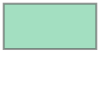

In [5]:
# Set study area name for outputs
study_area = "incheon"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Load data

In [6]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Load data using odc-stac
satellite_ds = load_ls_s2(
    geom=geom,
    resolution=resolution,
    start_date=start_date,
    end_date=end_date,
    cloud_cover=80,
)
print(satellite_ds)

# Load data and close dask client
satellite_ds.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33273,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:45557,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40387/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:38585,


Found 121 STAC items for landsat-c2-l2
Found 563 STAC items for sentinel-2-l2a
<xarray.Dataset>
Dimensions:      (y: 583, x: 922, time: 409)
Coordinates:
  * y            (y) float64 4.168e+06 4.168e+06 4.168e+06 ... 4.15e+06 4.15e+06
  * x            (x) float64 2.522e+05 2.523e+05 ... 2.798e+05 2.799e+05
    spatial_ref  int32 32652
  * time         (time) datetime64[ns] 2020-01-03T02:20:59.024000 ... 2022-12...
Data variables:
    ndwi         (time, y, x) float64 dask.array<chunksize=(1, 583, 922), meta=np.ndarray>


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
Ignoring read failure while reading: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2022/117/034/LC09_L2SP_117034_20220401_20220405_02_T1/LC09_L2SP_117034_20220401_20220405_02_T1_QA_PIXEL.TIF?st=2024-04-10T04%3A54%3A53Z&se=2024-04-12T04%3A54%3A53Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-04-10T20%3A00%3A58Z&ske=2024-04-17T20%3A00%3A58Z&sks=b&skv=2021-06-

<xarray.Dataset>
Dimensions:      (y: 583, x: 922, time: 409)
Coordinates:
  * y            (y) float64 4.168e+06 4.168e+06 4.168e+06 ... 4.15e+06 4.15e+06
  * x            (x) float64 2.522e+05 2.523e+05 ... 2.798e+05 2.799e+05
    spatial_ref  int32 32652
  * time         (time) datetime64[ns] 2020-01-03T02:20:59.024000 ... 2022-12...
Data variables:
    ndwi         (time, y, x) float64 0.6937 0.697 0.6914 0.6969 ... nan nan nan

## Pixel-based tides

In [7]:
# Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
tide_m, _ = pixel_tides(
    satellite_ds,
    resample=True,
    model=tide_model,
    directory=tide_model_dir,
    parallel_splits=10,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 10/10 [00:55<00:00,  5.59s/it]


Reprojecting tides into original array


In [8]:
# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that we ignore any tide observations where we don't
# have matching satellite imagery
satellite_ds["tide_m"] = tide_m.where(
    ~satellite_ds.to_array().isel(variable=0).isnull().drop("variable")
)

## Pixel-based DEM creation

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

In [9]:
%%time
flat_ds, freq, corr = ds_to_flat(
    satellite_ds,
    ndwi_thresh=0.0,
    min_freq=0.02,
    max_freq=0.98,
    min_correlation=0.20,
)

Reducing analysed pixels from 537526 to 183447 (34.13%)
CPU times: user 7.22 s, sys: 4.44 s, total: 11.7 s
Wall time: 11.3 s


### Pixel-wise rolling median
This function performs a rolling median calculation along the tide heights of our satellite images. 
It breaks our tide range into `windows_n` individual rolling windows, each of which covers `windows_prop_tide` of the full tidal range. 
For each window, the function returns the median of all tide heights and NDWI index values within the window, and returns an array with a new "interval" dimension that summarises these values from low to high tide.

In [10]:
interval_ds = pixel_rolling_median(
    flat_ds,
    windows_n=100,
    window_prop_tide=0.15,
    max_workers=None,
    min_count=5,
)

  0%|          | 0/105 [00:00<?, ?it/s]

### Model intertidal elevation and uncertainty

In [11]:
# Model elevation
flat_dem = pixel_dem(
    interval_ds,
    ndwi_thresh=ndwi_thresh,
    interp_intervals=200,
    smooth_radius=20,
    min_periods=5,
)

Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


In [12]:
# Model uncertainty
low, high, uncertainty, misclassified = pixel_uncertainty(
    flat_ds, flat_dem, ndwi_thresh, method="mad"
)

# Add arrays to dataset
flat_dem[["elevation_low", "elevation_high", "elevation_uncertainty"]] = (
    low,
    high,
    uncertainty,
)

## Unstack outputs and export

In [13]:
# Combine QA layers with elevation layers
flat_combined = xr.combine_by_coords(
    [flat_dem,  # DEM data
     freq,  # Frequency
     corr,  # Correlation
    ],
)

# Unstack elevation and uncertainty layers back into their original 
# spatial dimensions
ds = flat_to_ds(flat_combined, satellite_ds)

# Clean upper edge of intertidal zone in elevation layers 
# (likely to be inaccurate edge pixels)
elevation_bands = [d for d in ds.data_vars if "elevation" in d]
ds[elevation_bands] = clean_edge_pixels(ds[elevation_bands])

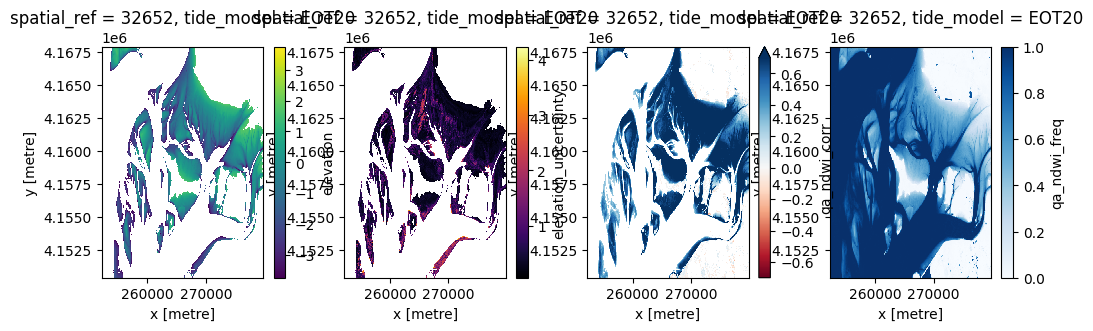

In [14]:
fix, axes = plt.subplots(1, 4, figsize=(12, 3))
ds.elevation.plot.imshow(cmap="viridis", ax=axes[0])
ds.elevation_uncertainty.plot.imshow(cmap="inferno", ax=axes[1])
ds.qa_ndwi_corr.plot.imshow(cmap="RdBu", vmin=-0.7, vmax=0.7, ax=axes[2])
ds.qa_ndwi_freq.plot.imshow(cmap="Blues", vmin=0, vmax=1, ax=axes[3])

In [18]:
ds.elevation.odc.explore(robust=True)

### Export to GeoTIFF files

In [16]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

### Close Dask client

In [17]:
client.close()